# Introduction

- 주제: 농수산물 별 물가 상승 정도 분석 및 경매 가격 분석 시각화
- 목표: 데이터 분석 프로젝트 진행, 시각화로 포트폴리오 만들기
- 기간: 22/07/25 ~ 22/08/05
- 팀원: 이진규
- 데이터: 서울열린데이터광장 : 농수산물 경매 정보 (http://data.seoul.go.kr/dataList/OA-2662/S/1/datasetView.do#)

## column info

값 | 의미
---|:---:|
`prd` | 품목명, 카테고리별로 전처리 |
`scale` | 판매 단위 (kg) |
`price` | 판매 가격 (₩) |
`reg_date` | 등록일 |
`new_class` | 상품 등급, 1이 가장 높음 |
`price_kg` | kg 당 가격 |
`state` | 도단위, 해외는 수입 |
`city` | 시단위, 해외는 국가명 |

## Initialize

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
pd.options.display.float_format = '{:.5f}'.format
data = "/Users/luci031/Desktop/Coding/g_auction"

# matplotlib 폰트설정
plt.rc('font', family='AppleGothic') # For MacOS
# plt.rc('font', family='NanumGothic') # For Windows
print(plt.rcParams['font.family'])

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.

plt.rcParams['axes.unicode_minus'] = False

['AppleGothic']


In [2]:
# 데이터 불러오기
df_lst = []
for i in range(1,19):
    if i < 13:
        if i < 10:
            name = "df210"+str(i)
            df_name = "20210"+str(i)
        else:
            name = "df21"+str(i)
            df_name = "2021"+str(i)
    else:
        a = i%12
        name = "df220"+str(a)
        df_name = "20220"+str(a)
    name = pd.read_csv(data+"/data_proceed/"+df_name+"_proceed.csv")
    df_lst.append(name)


In [3]:
# 보기 옵션
pd.set_option('display.max_rows', 30)
# pd.reset_option('display.max_rows')

## Pre-processing

In [4]:
# 데이터 전처리
for df in df_lst:
    df.reset_index(inplace=True,drop=True)
    df.drop(columns=['Unnamed: 0'],inplace=True)

In [5]:
# 모든 데이터 통합
df = df_lst[0]
for dfs in df_lst[1:]:
    df = pd.concat([df,dfs])
df.reset_index(inplace=True,drop=True)

In [6]:
# 기존 데이터의 전처리가 완료된 상태기 때문에 null값 없음
df.isnull().sum()

prd          0
scale        0
price        0
eco          0
reg_date     0
new_class    0
price_kg     0
state        0
city         0
dtype: int64

In [7]:
# scale 값이 0인 이상치 발견하여 삭제
df.drop(df[df['scale']==0].index,inplace=True)

In [8]:
# reg_date datetime format으로 변경
df['reg_date'] = pd.to_datetime(df['reg_date'])

# EDA

## Basic Info

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11141586 entries, 0 to 11141588
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   prd        object        
 1   scale      float64       
 2   price      int64         
 3   eco        object        
 4   reg_date   datetime64[ns]
 5   new_class  int64         
 6   price_kg   float64       
 7   state      object        
 8   city       object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 850.0+ MB


In [10]:
df.describe()

,scale,price,new_class,price_kg
count,11141586.00000,11141586.00000,11141586.00000,11141586.00000
mean,8.45508,23027.53212,1.56489,4375.88803
std,120.89900,108435.25502,1.67264,25900.33197
min,0.02000,500.00000,1.00000,0.40000
25%,3.00000,8000.00000,1.00000,1600.00000
50%,5.00000,15000.00000,1.00000,2857.14000
75%,10.00000,27000.00000,1.00000,5222.22000
max,18000.00000,99999999.00000,9.00000,49999999.50000


In [11]:
# 상관관계 탐색
# scale과 price가 상관관계가 꽤 있지만 생각보다 크진 않다 (price_kg는 price로부터 생성된 계산값이기 때문에 논외)
df.corr()

,scale,price,new_class,price_kg
scale,1.00000,0.46682,-0.00314,-0.00446
price,0.46682,1.00000,-0.01486,0.67270
new_class,-0.00314,-0.01486,1.00000,-0.01181
price_kg,-0.00446,0.67270,-0.01181,1.00000


In [12]:
# 날짜별 데이터 분포 탐색
counter = df.groupby(['reg_date']).count()

In [13]:
# 거래가 1개 뿐인 날짜 발견 -> 전체 목록에서 삭제 -> 이후 다시 불러오기
df.drop(df[df['reg_date']=='2021-04-18'].index,inplace=True)
counter = df.groupby(['reg_date']).count()

In [39]:
# 일자별 거래량
df.groupby(['reg_date'])['prd'].count().describe()

count     451.00000
mean    24703.68514
std      9808.83866
min       501.00000
25%     17996.00000
50%     20959.00000
75%     34268.00000
max     50852.00000
Name: prd, dtype: float64

In [44]:
# 가장 거래량이 많은 날은 22년 6월 20일
# 거래량이 적은 날은 21년 6월 20일
c = df.groupby(['reg_date']).count()
c[(c['prd']==50852) | (c['prd']==501)]

,prd,scale,price,eco,new_class,price_kg,state,city
reg_date,,,,,,,,
2021-06-28,501,501,501,501,501,501,501,501
2022-06-20,50852,50852,50852,50852,50852,50852,50852,50852


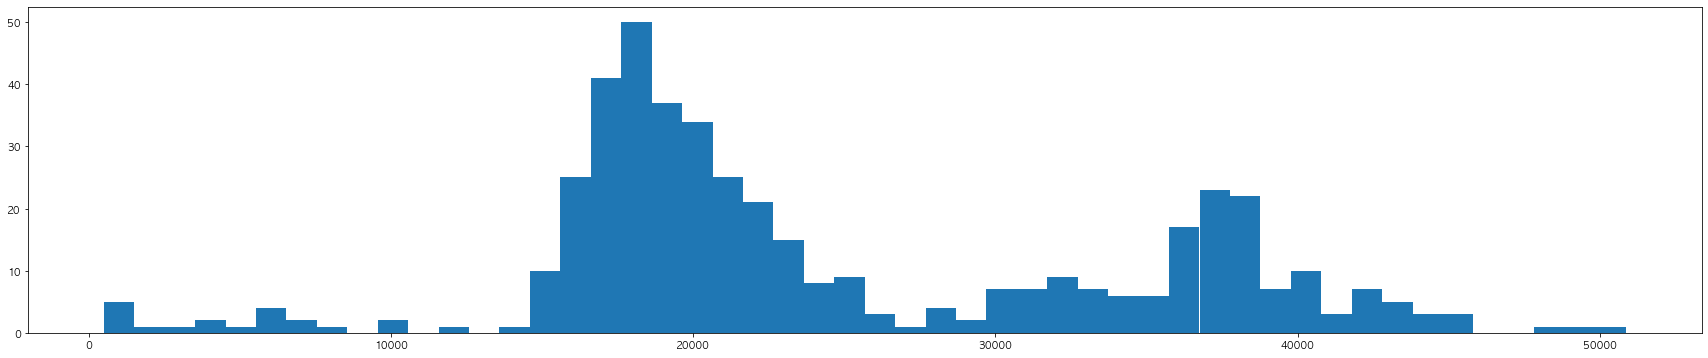

In [51]:
# 일자별 데이터 분포 1
# 평균적으로 15000~25000 건 사이의 거래가 이루어짐
plt.figure(figsize=(30,6))
plt.hist(c['prd'],bins=50)
plt.show()

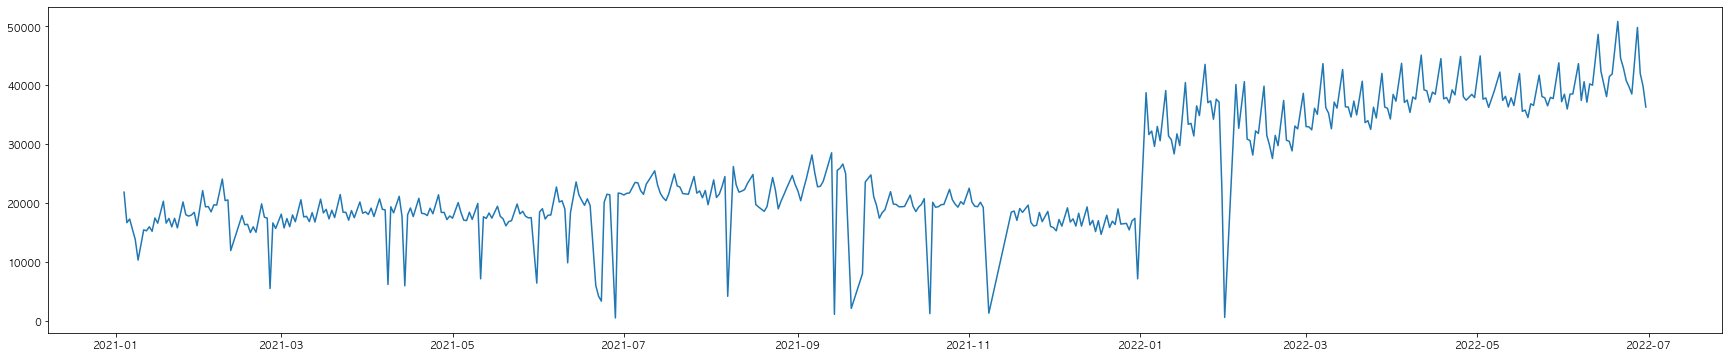

In [53]:
# 일자별 데이터 분포 2
# 데이터 양의 차이로 22년 거래가 상대적으로 더 많은 것 확인
# 주기적으로 거래량이 작은 날짜 확인 필요
plt.figure(figsize=(30,6))
plt.plot(c['prd'])
plt.show()

In [67]:
# 공휴일 등의 날짜는 아닌 듯
days = c[c['prd']<=10000].index.tolist()
days

[Timestamp('2021-02-25 00:00:00'),
 Timestamp('2021-04-08 00:00:00'),
 Timestamp('2021-04-14 00:00:00'),
 Timestamp('2021-05-11 00:00:00'),
 Timestamp('2021-05-31 00:00:00'),
 Timestamp('2021-06-11 00:00:00'),
 Timestamp('2021-06-21 00:00:00'),
 Timestamp('2021-06-22 00:00:00'),
 Timestamp('2021-06-23 00:00:00'),
 Timestamp('2021-06-28 00:00:00'),
 Timestamp('2021-08-07 00:00:00'),
 Timestamp('2021-09-14 00:00:00'),
 Timestamp('2021-09-20 00:00:00'),
 Timestamp('2021-09-24 00:00:00'),
 Timestamp('2021-10-18 00:00:00'),
 Timestamp('2021-11-08 00:00:00'),
 Timestamp('2021-12-31 00:00:00'),
 Timestamp('2022-01-31 00:00:00')]

In [71]:
# 일별로 확인 결과, 
from collections import defaultdict as d
week = ['월','화','수','목','금','토','일']
lst = d(int)
for day in days:
    a = week[day.weekday()]
    lst[a] += 1

# 상대적으로 월요일이 많긴 하나, 도드라질 정도는 아님
lst

defaultdict(int, {'목': 2, '수': 2, '화': 3, '월': 7, '금': 3, '토': 1})

## Column 별 탐색

### 연속형 데이터 탐색 (Scale,Price,New_class,Price_kg)

In [17]:
# 대략적인 데이터 정보
df.describe()

,scale,price,new_class,price_kg
count,11141585.00000,11141585.00000,11141585.00000,11141585.00000
mean,8.45508,23027.53253,1.56489,4375.88826
std,120.89901,108435.25988,1.67264,25900.33312
min,0.02000,500.00000,1.00000,0.40000
25%,3.00000,8000.00000,1.00000,1600.00000
50%,5.00000,15000.00000,1.00000,2857.14000
75%,10.00000,27000.00000,1.00000,5222.22000
max,18000.00000,99999999.00000,9.00000,49999999.50000


In [18]:
# price_kg 비율이 35만원 이상 차이나는 값들 -> 이상치라 판단하고 제거
df.drop(df[df['price_kg']>=350000].index,inplace=True)

In [38]:
# scale TOP 10
df.sort_values('scale', ascending=False).head(10)

,prd,scale,price,eco,reg_date,new_class,price_kg,state,city
4881600,무,18000.00000,11000000,normal,2021-11-06,1,611.11000,전북,부안
4884303,무,10000.00000,2500000,normal,2021-11-26,1,250.00000,충남,서산
4884301,무,10000.00000,6500000,normal,2021-11-26,1,650.00000,전남,영암
4884300,무,10000.00000,3370000,normal,2021-11-26,1,337.00000,전북,부안
4884299,무,10000.00000,8510000,normal,2021-11-26,1,851.00000,전북,부안
4884298,무,10000.00000,8770000,normal,2021-11-26,1,877.00000,전북,부안
4884297,무,10000.00000,4030000,normal,2021-11-26,1,403.00000,전남,영암
5516730,무,10000.00000,1690000,normal,2021-12-10,1,169.00000,전북,고창
4884296,무,10000.00000,3880000,normal,2021-11-26,1,388.00000,전북,부안
4884295,무,10000.00000,2660000,normal,2021-11-26,1,266.00000,전북,부안


In [ ]:
# price TOP 10

In [37]:
# class 분포
class_count = df.groupby(['new_class']).count()
class_count['percent'] = class_count['prd']/len(df)
class_count[['prd','percent']]

,prd,percent
new_class,,
1,8930294,0.80154
2,1138002,0.10214
3,489919,0.04397
4,47363,0.00425
5,51337,0.00461
6,12316,0.00111
7,4413,0.00040
8,1338,0.00012
9,466380,0.04186


**결과**
- Scale
    - 평균적인 거래량은 약 8.455 kg
    - 최소 거래량은 0.02 kg 짜리 거래 (느타리버섯, 깻잎)
    - 최대 1회 거래량은 18톤 가량의 '무' 거래
- Price (Price_kg)
    - 최대 거래 금액은 99999999원 -> 이상 거래라 판단하고 확인 진행
    - 확인 결과, kg 당 금액이 35만원 이상의 거래의 경우 이상치라 판단, 삭제
    - 평균적인 거래 금액은 약 22800원
    - 최소 거래 금액을 500원으로 전처리 했기 때문에 500원
    - 최대 거래 금액은 15000000원의 '무' 거래, 10톤 거래되었음
- New_class
    - 평균적인 등급은 약 1.56 등급, 1급이 가장 높은 등급임을 감안하면 품질이 전체적으로 좋은 편
    - 전체적인 분포 및 표준편차로 봤을 때 1등급이 가장 많음 (80% 가량)

In [20]:
df[df['price']==15000000]

,prd,scale,price,eco,reg_date,new_class,price_kg,state,city
4882522,무,10000.00000,15000000,normal,2021-11-18,1,1500.00000,전남,무안


### prd

In [21]:
# 품목 수
len(df['prd'].unique())


207

In [22]:
# 물품별 판매건수 TOP 10
prd_sold = df.groupby(['prd']).count()
prd_sold.sort_values('scale', ascending=False).head(10)


,scale,price,eco,reg_date,new_class,price_kg,state,city
prd,,,,,,,,
딸기,872399,872399,872399,872399,872399,872399,872399,872399
버섯,850523,850523,850523,850523,850523,850523,850523,850523
오이,611242,611242,611242,611242,611242,611242,611242,611242
토마토,574963,574963,574963,574963,574963,574963,574963,574963
참외,505725,505725,505725,505725,505725,505725,505725,505725
호박,427460,427460,427460,427460,427460,427460,427460,427460
고추,425037,425037,425037,425037,425037,425037,425037,425037
깻잎,406619,406619,406619,406619,406619,406619,406619,406619
양채류,376880,376880,376880,376880,376880,376880,376880,376880


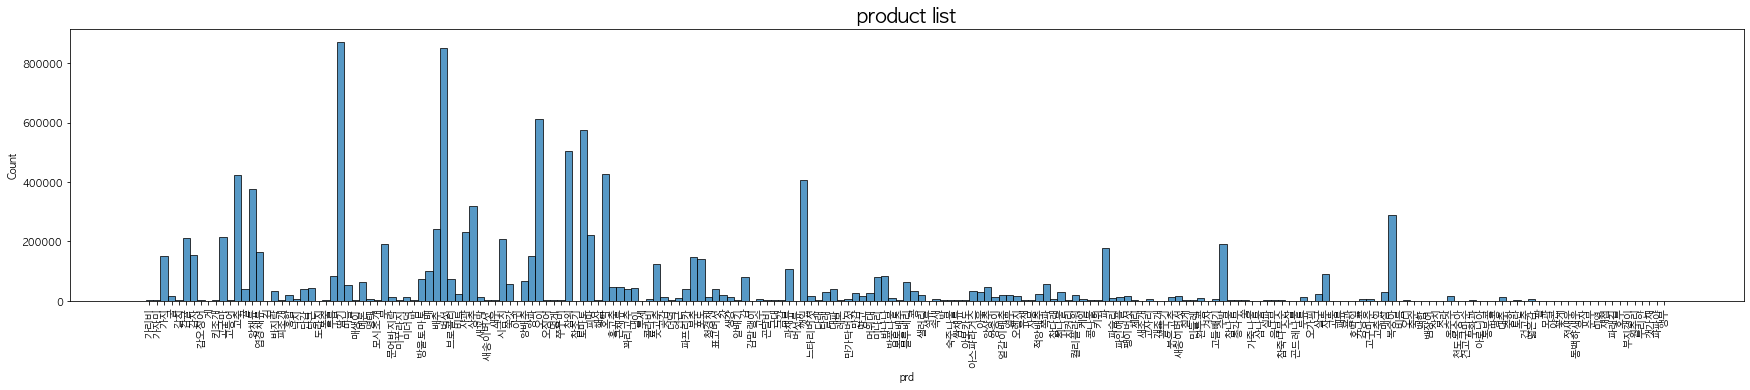

Product 종류 수: 207
Product 최대 거래수: 872399
Product 최소 거래수: 50


In [23]:
# 하스토그램을 이용해 Store를 시각화하여 품목들의 거래량 분포 확인
plt.figure(figsize=(30,5))
sns.histplot(df['prd'], bins=45)
plt.title("product list", size=20)
plt.xticks(rotation=90)
plt.show()

# 명확한 숫자를 확인하기 위해 수치를 출력
print(f"Product 종류 수: {len(df['prd'].unique())}")
print(f"Product 최대 거래수: {df['prd'].value_counts().max()}")
print(f"Product 최소 거래수: {df['prd'].value_counts().min()}")

In [24]:
# 품목별 판매량, 판매 가격 확인
# prd_sales = df.groupby(['prd']).agg(['sum','mean','max','min'])
# prd_sales
# plt.figure(figsize = (30,5))
# sns.histplot(prd_sales)
# plt.title("product sales", size=20)
# plt.xticks(rotation=90)
# plt.show()

# print('-Scale-')
# print(f"Product 평균 거래 무게: {prd_sales['scale'].mean()}")
# print(f"Product 최소 거래 무게: {prd_sales['scale'].min()}")
# print(f"Product 최대 거래 무게: {prd_sales['scale'].max()}")
# print('-Price')
# print(f"Product 평균 거래 가격: {prd_sales['price'].mean()}")
# print(f"Product 최소 거래 가격: {prd_sales['price'].min()}")
# print(f"Product 최대 거래 가격: {prd_sales['price'].max()}")